In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
#from cur import cur_decomposition
from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.datasets import fashion_mnist  #
from keras.datasets import cifar10  #
from keras.models import Sequential, Model  # Model type to be used
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation, Conv1D, LocallyConnected1D, Reshape, Softmax, Input
#from keras.utils import np_utils
import tensorflow as tf
import tensorflow.keras.backend as kb
from datetime import datetime
from tqdm.notebook import tqdm

In [ ]:
@tf.function
def get_hessian1(model,input,target, lossfunc = tf.keras.losses.CategoricalCrossentropy()):
    loss = lossfunc(model(input),target)
    return tf.hessians(loss, input)

In [ ]:
@tf.function
def get_hessian2(model,input,target, lossfunc = tf.keras.losses.CategoricalCrossentropy()):
    with tf.GradientTape() as t2:
      t2.watch(input)
      with tf.GradientTape() as t1:
        t1.watch(input)
        loss = lossfunc(model(input),target)
      g=t1.gradient(loss,input)
    return t2.jacobian(g,input)

In [ ]:
def ManifoldAngles(layerfeatlist,neighboursize1=10,classsize=10,dim_reduc_size=3,fileloc = "layers/"):

  starttime = tf.timestamp()
  tf.print("start: ")

  no_of_layers = len(layerfeatlist)
  reduction_quality = []
  class_chars = []

  for c1 in range(classsize):
    class_chars.append([])
    for layer_i in range(no_of_layers):
      class_chars[c1].append(LayerCharacteristics())
      layer_features = layerfeatlist[layer_i]

      layer_start = tf.timestamp()

      for i,x_i in enumerate(layer_features):

        class_chars[c1][layer_i].neighbour_dict[i] = tf.argsort(tf.norm( tf.math.subtract(layer_features,x_i) ,axis=1))[0:neighboursize1+1]# [1:neighboursize1+1]#templist

        W_i = tf.gather(layer_features,class_chars[c1][0].neighbour_dict[i])
        #class_chars[c1][layer_i].distances[i] = tf.math.reduce_euclidean_norm( tf.math.subtract( W_i , x_i ),axis=1)

        W_i = ( W_i - tf.math.reduce_mean(W_i,axis=0) )
        s, u, v = tf.linalg.svd( W_i )
        W_i_reduced = v[:,:dim_reduc_size]

        class_chars[c1][layer_i].svd_weights[i] = s[:dim_reduc_size]
        reduction_quality.append(  tf.reduce_sum( (s[:dim_reduc_size])/ tf.reduce_sum(s) ) )
        #tf.print("Reduction quality: ",  reduction_quality[-1])
        #if reduction_quality[-1] < 0.9: tf.print("Warning! Reduction quality: ",  reduction_quality[-1], i)
        class_chars[c1][layer_i].U_dict[i] = W_i_reduced

      tf.print("--layer time: ", tf.timestamp() - layer_start)
      class_chars[c1][layer_i].space_linearity_sum = 0.0
      angle_start = tf.timestamp()

      manifold_neighbour_angle_sum=[]
      for i in range(len(class_chars[c1][layer_i].U_dict)):
        manifold_neighbour_angle_sum_temp=[]
        manifold_neighbour_angle_sum.append([])

        for j in class_chars[c1][0].neighbour_dict[i]:
          if i != j:
            teta =  tf.matmul(  tf.transpose(class_chars[c1][layer_i].U_dict[i]),  class_chars[c1][layer_i].U_dict[int(j)]   )
            weights =  tf.matmul(  tf.transpose( tf.expand_dims(class_chars[c1][layer_i].svd_weights[i],0)), tf.expand_dims(class_chars[c1][layer_i].svd_weights[int(j)],0)  )
            Q = teta*weights
            #tf.print(i,"-----", j)
            #Q =  tf.matmul(  tf.transpose( tf.matmul( class_chars[c1][layer_i].U_dict[i], np.diag(class_chars[c1][layer_i].svd_weights[i]) ) ), tf.matmul( class_chars[c1][layer_i].U_dict[int(j)], np.diag(class_chars[c1][layer_i].svd_weights[int(j)]) ) )

            s, u, v = tf.linalg.svd( Q )

            tetaw = tf.reduce_sum(s)/tf.linalg.trace(weights)
            angles = tf.math.acos( tf.clip_by_value(tetaw,-1,1) )
            manifold_neighbour_angle_sum_temp.append( tf.math.sin(angles)  )

        #manifold_neighbour_angle_sum[i].append(tf.reduce_mean(tf.convert_to_tensor(manifold_neighbour_angle_sum_temp)) * tf.reduce_mean(class_chars[c1][layer_i].distances[i]) )
        manifold_neighbour_angle_sum[i].append(tf.reduce_mean(tf.convert_to_tensor(manifold_neighbour_angle_sum_temp)))
      #class_chars[c1][layer_i].space_linearity_sum = tf.reduce_sum( tf.convert_to_tensor(manifold_neighbour_angle_sum )) / tf.reduce_sum([tf.reduce_mean( x ) for x in list(class_chars[c1][layer_i].distances.values())])
      class_chars[c1][layer_i].space_linearity_sum = tf.reduce_mean( tf.convert_to_tensor(manifold_neighbour_angle_sum ))
      tf.print("--angle time: ", tf.timestamp() - angle_start)

  #tf.print("endtime: ", tf.timestamp() - starttime)
  if no_of_layers==1: tf.print("Average reduction quality: ",  tf.reduce_mean(reduction_quality))
  tf.print("endtime: ", tf.timestamp() - starttime)
  return class_chars,manifold_neighbour_angle_sum

In [ ]:
(X_train, train_y), (X_test, test_y) = mnist.load_data()
X_train = X_train / 255
X_test = X_test/ 255

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
Y_train = np_utils.to_categorical(train_y, 10)
Y_test = np_utils.to_categorical(test_y, 10)

In [ ]:
class LayerCharacteristics():
    def __init__(self):
      self.space_linearity_sum = []
      self.total_sum = []
      self.svd_weights = {}
      self.distances = {}
      self.neighbour_dict = {}
      self.U_dict = {}

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv2D(50, kernel_size=(28,28), input_shape=(28,28,1), activation='tanh',use_bias=False, kernel_initializer='random_uniform',padding='valid'))
  #model.add(MaxPooling2D(pool_size=(2, 2)))#model.add(tf.keras.layers.BatchNormalization())
  model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
  model.add(Dense(10, activation='linear', kernel_initializer= 'random_uniform'))
  model.add(tf.keras.layers.Softmax())

  return model

In [ ]:
nt = create_model()
nt.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1, 1, 50)          39200     
                                                                 
 flatten_4 (Flatten)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 softmax_1 (Softmax)         (None, 10)                0         
                                                                 
Total params: 39,710
Trainable params: 39,710
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
history  = nt.fit(X_train, Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=1, batch_size = 128  ) #, callbacks=[callback]
print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")


Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 0.5890 - categorical_accuracy: 0.8696 - val_loss: 0.2761 - val_categorical_accuracy: 0.9230
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2423 - categorical_accuracy: 0.9310 - val_loss: 0.2108 - val_categorical_accuracy: 0.9389
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1907 - categorical_accuracy: 0.9457 - val_loss: 0.1779 - val_categorical_accuracy: 0.9469
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1595 - categorical_accuracy: 0.9544 - val_loss: 0.1579 - val_categorical_accuracy: 0.9536
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1375 - categorical_accuracy: 0.9615 - val_loss: 0.1417 - val_categorical_accuracy: 0.9587
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1206 - categorical_accuracy: 0.9662 - val_loss: 0.1341 - val_categorical_accuracy: 0.9606
Epoc

In [ ]:
modelnamelist = [nt]
data_at_once = 500
number_of_data = 500
performancelist = {}
for model in modelnamelist:

  class_curvature = []
  #class_pointcurv = []

  for classno in range(2):
    outputs = None
    for i in range((number_of_data//data_at_once)):

        images = X_train[train_y==classno][i*data_at_once:(i+1)*data_at_once]
        labels = Y_train[train_y==classno][i*data_at_once:(i+1)*data_at_once]

        images, labels
        if outputs is None: outputs = model(images)
        else: outputs = tf.concat([outputs, model(images)],0)
        # the class with the highest energy is what we choose as prediction
        #_, predicted = torch.max(outputs.data, 1)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
        #print(f'Accuracy of the network on the {i*batch_size} train images: {100 * correct / total} %')

    lowersize = 10
    s,u,v = tf.linalg.svd(tf.keras.layers.Flatten()(images))
    layerdata = (u[:,:lowersize]*s[:lowersize]).numpy()
    tf.print('layer quality: ', tf.norm(s[:lowersize]) / tf.norm(s))
    del s,u,v

    #perturbations0 = create_adversarial_pattern( model, images, labels)

    layerfeatlist = [layerdata]
    layerfeatlist.append( outputs )

    #layerfeatlist = [ imagesc[labelsc==classno][:number_of_data], outputs ]
    #layerfeatlist = [ outputs , curvature_features ]
    results,manifold_neighbour_angle_sum =  ManifoldAngles(layerfeatlist, classsize= 1,neighboursize1=5 ,dim_reduc_size=10,fileloc = "None")
    #class_pointcurv.append([manifold_neighbour_angle_sum])
    class_curvature.append([results[0][1].space_linearity_sum.numpy()])
    #class_curvature[-1].append(results[0][1].space_linearity_sum.numpy())
    print( f'Curvature of class {classno} is: {class_curvature[-1]}')
  print( f'Average curvature is: {np.sum(class_curvature)/10}')
  performancelist[classno] = class_curvature

  #print("Overall Time (minutes): ", start.elapsed_time(end)/60000)
  print("--------------------------------------------------------------------------------------------------")

layer quality:  0.925662935
start: 
--layer time:  2.0733377933502197
--angle time:  4.3787980079650879
--layer time:  1.5489799976348877
--angle time:  4.3415200710296631
endtime:  12.368762016296387
Curvature of class 0 is: [0.3710722]
layer quality:  0.948050737
start: 
--layer time:  2.0904538631439209
--angle time:  4.2576169967651367
--layer time:  1.5323469638824463
--angle time:  4.4656989574432373
endtime:  12.361264944076538
Curvature of class 1 is: [0.26963848]
Average curvature is: 0.0640710711479187
--------------------------------------------------------------------------------------------------


In [ ]:
@tf.function
def compute_hes(model,input,target, lossfunc = tf.keras.losses.CategoricalCrossentropy()):
  loss = lossfunc(model(input),target)
  hes = tf.hessians(loss, input)
  return  hes

In [ ]:
 x = tf.convert_to_tensor(images[0:1])

In [ ]:
Hes = compute_hes(nt,X_train[0:1],Y_train[0:1])

In [ ]:
len(Hes)

1

In [ ]:
Hes[0].shape

TensorShape([1, 28, 28, 1, 28, 28])

In [ ]:
np.linalg.norm(Hes[0])

226.159089332204

In [ ]:
Hes1 = get_hessian1(nt,X_train[0:1],Y_train[0:1])

In [ ]:
np.linalg.norm(Hes1[0])

226.159089332204

In [ ]:
Hes2 = get_hessian2(nt,X_train[0:1],Y_train[0:1])

In [ ]:
np.linalg.norm(Hes2[0])

226.15909077101227

In [ ]:
ModelPreSoftmax = Model(inputs = nt.input, outputs = nt.layers[-2].output )

In [ ]:
Hes_pre1 = get_hessian1(ModelPreSoftmax,X_train[0:10],Y_train[0:10])

In [ ]:
Hes_pre1[0].shape

TensorShape([10, 28, 28, 10, 28, 28])

In [ ]:
np.linalg.norm(Hes_pre1[0])

274.3881147116871

In [ ]:
Hes_pre2 = get_hessian2(ModelPreSoftmax,x)

In [ ]:
np.linalg.norm(Hes_pre2[0])

41.5115644943078

In [ ]:
np.linalg.norm(Hes1[0]-Hes2[0])

3.816086309718377e-05

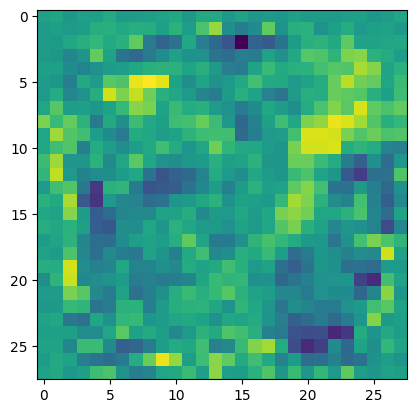

In [ ]:
plt.imshow(Hes1[0][0,20,0,0])

In [ ]:
Hes1[0].numpy().reshape((28*28,28,28)).shape

(784, 28, 28)

In [ ]:
Hes1[0].numpy().reshape((28*28,28*28)).shape

(784, 784)

In [ ]:
Hes1[0].numpy().reshape((28*28,28*28))

In [ ]:
s,u,v = tf.linalg.svd(Hes1[0].numpy().reshape((28*28,28*28)))

In [ ]:
plt.plot(s)

In [ ]:
s

<tf.Tensor: shape=(784,), dtype=float64, numpy=
array([3.18873430e-05, 4.17501806e-06, 3.71017225e-06, 2.39645935e-06,
       2.12528347e-06, 1.89058309e-06, 1.30415130e-06, 1.25318878e-06,
       1.17115774e-06, 1.05713577e-06, 9.36260228e-07, 8.78131115e-07,
       8.08015749e-07, 6.12714653e-07, 5.70999061e-07, 5.22917168e-07,
       4.93188250e-07, 4.85361987e-07, 4.19544177e-07, 3.80988881e-07,
       3.72634862e-07, 3.34367064e-07, 2.93735235e-07, 2.64850745e-07,
       2.45178798e-07, 2.01908104e-07, 1.95647180e-07, 1.90192962e-07,
       1.41130997e-07, 1.32814888e-07, 1.25847996e-07, 9.51188351e-08,
       7.77400171e-08, 7.18586644e-08, 6.17257861e-08, 3.91929122e-08,
       3.41542909e-08, 1.73809396e-08, 1.15879389e-08, 6.92659090e-09,
       5.45865500e-09, 1.95381544e-09, 4.65795603e-10, 4.05964909e-10,
       1.16039992e-10, 2.16208887e-11, 8.02737691e-12, 1.96972393e-12,
       7.72858697e-13, 7.10453470e-13, 6.10514538e-13, 5.76377346e-13,
       5.35804590e-13, 5.2323

In [ ]:
tf.keras.losses.CategoricalCrossentropy()(nt(X_train[1:2]),Y_train[1:2])

<tf.Tensor: shape=(), dtype=float32, numpy=0.00021314381>

In [ ]:
nt(X_train[0:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[4.8864699e-08, 2.9483929e-06, 2.0083892e-06, 1.5661824e-01,
        1.1212818e-07, 8.4336936e-01, 3.5250746e-08, 5.5383375e-06,
        5.9238300e-07, 1.1648099e-06]], dtype=float32)>

In [ ]:
Y_train[0:1]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

---------------------

Taken from:
https://github.com/kuangliu/pytorch-cifar

In [ ]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

In [ ]:
import os
import argparse

In [ ]:
#parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
#parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
#parser.add_argument('--resume', '-r', action='store_true',help='resume from checkpoint')
#args = parser.parse_args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')



==> Preparing data..


100%|██████████| 170498071/170498071 [00:02<00:00, 82864685.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Model
print('==> Building model..')
# net = VGG('VGG19')
net = ResNet18()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF()
# net = SimpleDLA()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


==> Building model..


In [ ]:
from torchsummary import summary

In [ ]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
print('==> Resuming from checkpoint..')
#assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
checkpoint = torch.load('./ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

==> Resuming from checkpoint..


In [ ]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('train',100.*correct/total, correct, total)
        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'  % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total

    print('test',100.*correct/total, correct, total)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc



In [ ]:
for epoch in tqdm(range(start_epoch, start_epoch+50)):
    train(epoch)
    test(epoch)
    scheduler.step()

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0
train 28.974 14487 50000
test 40.66 4066 10000
Saving..

Epoch: 1
train 43.35 21675 50000
test 49.33 4933 10000
Saving..

Epoch: 2
train 52.784 26392 50000
test 56.09 5609 10000
Saving..

Epoch: 3
train 61.378 30689 50000
test 62.93 6293 10000
Saving..

Epoch: 4
train 67.25 33625 50000
test 67.27 6727 10000
Saving..

Epoch: 5
train 71.846 35923 50000
test 70.87 7087 10000
Saving..

Epoch: 6
train 75.15 37575 50000
test 72.56 7256 10000
Saving..

Epoch: 7
train 78.1 39050 50000
test 74.42 7442 10000
Saving..

Epoch: 8
train 79.494 39747 50000
test 76.84 7684 10000
Saving..

Epoch: 9
train 80.996 40498 50000
test 71.11 7111 10000

Epoch: 10
train 81.458 40729 50000
test 77.55 7755 10000
Saving..

Epoch: 11
train 82.634 41317 50000
test 75.09 7509 10000

Epoch: 12
train 83.458 41729 50000
test 76.66 7666 10000

Epoch: 13
train 83.854 41927 50000
test 79.79 7979 10000
Saving..

Epoch: 14
train 84.266 42133 50000
test 80.82 8082 10000
Saving..

Epoch: 15
train 84.51 42255 50000
te

In [ ]:
from functorch import jacrev, jacfwd
from functorch import hessian

In [ ]:
testloader.dataset.targets[0]

3

In [ ]:
#class Func(torch.autograd.Function):


In [ ]:
inputs, classes = next(iter(testloader))
inputs, classes = inputs.to(device), classes.to(device)

In [ ]:
inputs.shape

torch.Size([100, 3, 32, 32])

In [ ]:
net(inputs[0:1])

tensor([[ 0.2626, -0.6756,  0.3604,  1.0345, -0.3630,  0.0012,  0.1866, -0.1675,
         -0.2898, -0.3495]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
hess_fwdfwd = hessian(f)(inputs[0:1])

In [ ]:
J = torch.autograd.functional.jacobian(f, inputs[0:1])

In [ ]:
J.shape

torch.Size([1, 3, 32, 32])

In [ ]:
H = torch.autograd.functional.hessian(f, inputs[0:1])

In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader2 = torch.utils.data.DataLoader(
    trainset, batch_size=1, shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
datasetonebyone_inputs = []
datasetonebyone_targets = []
for batch_idx, (inputs, targets) in tqdm(enumerate(trainloader2 )):
  datasetonebyone_inputs.append(inputs)
  datasetonebyone_targets.append(targets)

In [ ]:
def f(x):
  return criterion(net(x), TARGET)

In [ ]:
pip install pyhessian

In [ ]:
import pyhessian

In [ ]:
from pyhessian import hessian

In [ ]:
hessian_dataloader = []
for i, (inputs, labels) in tqdm(enumerate(trainloader2)):
  hessian_comp = pyhessian.hessian(net, criterion, data=(inputs, labels))
  top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=10)

0it [00:00, ?it/s]

In [ ]:
hessian_comp = pyhessian.hessian(net, criterion, data=(inputs, labels))

/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=10)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e84b6923880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1409, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'


In [ ]:
top_eigenvalues

[0.4492744207382202,
 0.02009313926100731,
 -0.01655537635087967,
 0.015344669111073017,
 -0.01541403029114008,
 0.014591519720852375,
 -0.013745563104748726,
 0.012867540121078491,
 -0.013288615271449089,
 0.012727436609566212]

In [ ]:
HessianNormList = []
TargetList = []
idx_list = []
for batch_idx, (inputs, targets) in tqdm(enumerate(trainloader2 )):
  idx_list.append(batch_idx)
  TargetList.append(targets)
  inputs, targets = inputs.to(device), targets.to(device)
  TARGET = targets
  H = torch.autograd.functional.hessian(f, inputs) #, vectorize=True, outer_jacobian_strategy='forward-mode'
  HessianNormList.append( torch.linalg.norm(H).to('cpu').detach().numpy() )
  print(idx_list[-1], TargetList[-1], HessianNormList[-1])

In [ ]:
HessianNormList = []
TargetList = []
idx_list = []
for i, (inputs, labels) in tqdm(enumerate(trainloader2)):
  idx_list.append(i)
  TargetList.append(labels)
  hessian_comp = pyhessian.hessian(net, criterion, data=(inputs, labels))
  top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=3)
  HessianNormList.append( top_eigenvalues )

  inputs, targets = inputs.to(device), labels.to(device)
  TARGET = targets
  H = torch.autograd.functional.hessian(f, inputs) #, vectorize=True, outer_jacobian_strategy='forward-mode'

  print( torch.linalg.norm(H).to('cpu').detach().numpy() )
  print(idx_list[-1], TargetList[-1], HessianNormList[-1], np.linalg.norm(HessianNormList[-1]))

In [ ]:
inputs[0,0,0,0:5]

tensor([-2.4291, -2.4291, -2.4291, -2.4291, -2.4291], device='cuda:0')

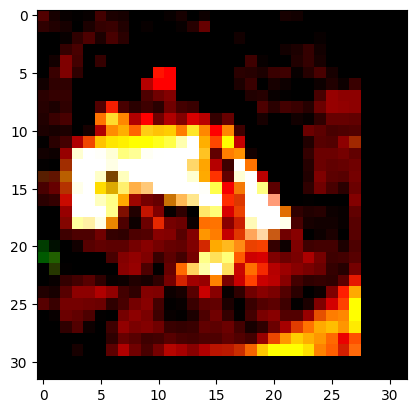

In [ ]:
plt.imshow(np.transpose(inputs.cpu()[0],[1,2,0]))

tensor([6])


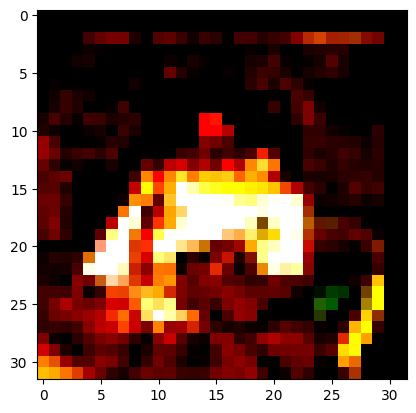

In [ ]:
inputs, classes = next(iter(trainloader2))
print( classes)
plt.imshow(np.transpose(inputs.cpu()[0],[1,2,0]))

0it [00:00, ?it/s]

0 tensor([6]) [796.90478515625, 24.930774688720703, 16.30291748046875] 797.4613252377094 7.159398
1 tensor([9]) [0.9721747636795044, 0.07527964562177658, 0.030514532700181007] 0.9755623675020223 0.0034162947
2 tensor([9]) [138.4568634033203, 14.011622428894043, 4.515111446380615] 139.23726088209588 2.6735175
3 tensor([4]) [1.4332536458969116, 0.2532091736793518, 0.09408221393823624] 1.4584863256443956 0.01997391
4 tensor([1]) [0.12185072898864746, 0.005017957184463739, -0.004131587687879801] 0.1220239733257058 0.0005940379
5 tensor([1]) [16.81159782409668, 2.3511781692504883, 0.8059444427490234] 16.994334545004413 0.07002383
6 tensor([2]) [135.75399780273438, 7.477521896362305, -3.1148698329925537] 135.9954545829083 1.1339691
7 tensor([7]) [1.3645460605621338, 0.0777541920542717, 0.05203309282660484] 1.3677496512617917 0.0098133655
8 tensor([8]) [4.2323222160339355, 0.18742252886295319, -0.14788207411766052] 4.239050324365722 0.03616028
9 tensor([3]) [916.1957397460938, 121.59047698974

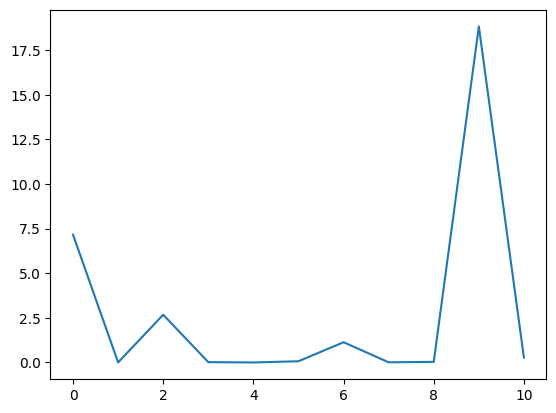

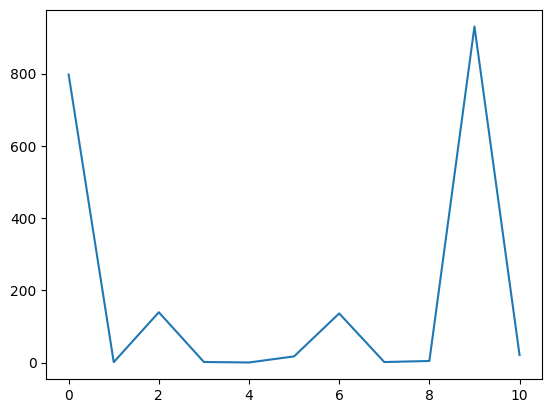

In [ ]:
HessianEigList = []
HessianEigNormList = []
TargetList = []
idx_list = []
HessianNormList_Functional = []
for i, (inputs, labels) in tqdm(enumerate(trainloader2)):
  idx_list.append(i)
  TargetList.append(labels)
  hessian_comp = pyhessian.hessian(net, criterion, data=(inputs, labels))
  top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=3)
  HessianEigList.append( top_eigenvalues )
  HessianEigNormList.append( np.linalg.norm(HessianEigList[-1])  )
  inputs, targets = inputs.to(device), labels.to(device)
  TARGET = targets
  H = torch.autograd.functional.hessian(f, inputs) #, vectorize=True, outer_jacobian_strategy='forward-mode'
  HessianNormList_Functional.append( torch.linalg.norm(H).to('cpu').detach().numpy() )
  print(idx_list[-1], TargetList[-1], HessianEigList[-1], HessianEigNormList[-1], HessianNormList_Functional[-1])
  if i == 10:
    break
plt.plot(HessianNormList_Functional)
plt.show()
plt.plot(HessianEigNormList)
plt.show()

0it [00:00, ?it/s]

0 tensor([6]) [964.2161254882812, 71.45519256591797, 30.078527450561523] 967.3279170011891 11.543627
1 tensor([9]) [0.02241084910929203, 0.002536279847845435, -0.0006908608484081924] 0.02256448895893513 7.740457e-05
2 tensor([9]) [3199.048583984375, 115.48558044433594, 96.9464111328125] 3202.6000950188163 79.95263
3 tensor([4]) [11.144478797912598, 1.6996101140975952, 0.5940141677856445] 11.288974047653593 0.14565153
4 tensor([1]) [0.07232826203107834, 0.0036793192848563194, -0.0020689312368631363] 0.07245133094222019 0.0004257156
5 tensor([1]) [221.71142578125, 22.28154182434082, 8.02778148651123] 222.97279812483796 1.0512102
6 tensor([2]) [2.5318164825439453, 0.12653689086437225, 0.06530006229877472] 2.535817498197976 0.0150318025
7 tensor([7]) [3.6181535720825195, 0.2340555489063263, 0.13570953905582428] 3.6282550007046197 0.024247121
8 tensor([8]) [25.790340423583984, 0.6948445439338684, -0.18846476078033447] 25.800387343422596 0.1464796
9 tensor([3]) [1199.2750244140625, 149.65303

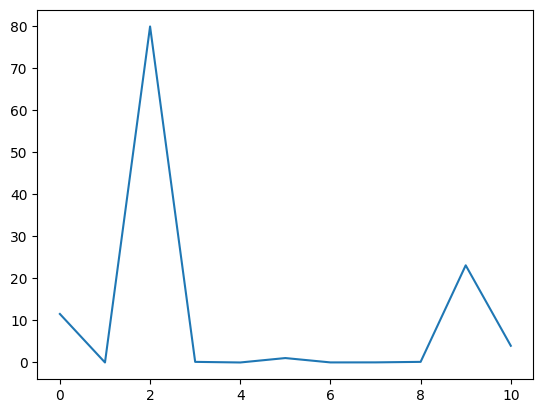

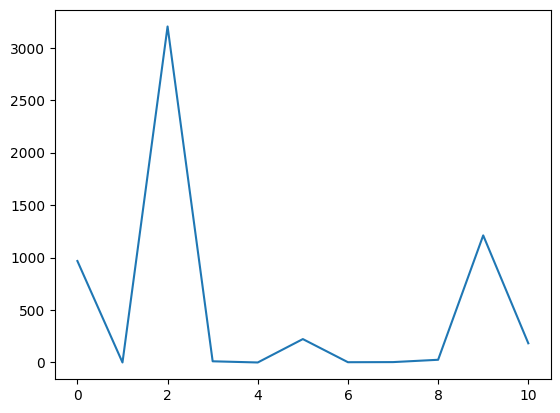

In [ ]:
HessianEigList = []
HessianEigNormList = []
TargetList = []
idx_list = []
HessianNormList_Functional = []
for i, (inputs, labels) in tqdm(enumerate(trainloader2)):
  idx_list.append(i)
  TargetList.append(labels)
  hessian_comp = pyhessian.hessian(net, criterion, data=(inputs, labels))
  top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=3)
  HessianEigList.append( top_eigenvalues )
  HessianEigNormList.append( np.linalg.norm(HessianEigList[-1])  )
  inputs, targets = inputs.to(device), labels.to(device)
  TARGET = targets
  H = torch.autograd.functional.hessian(f, inputs) #, vectorize=True, outer_jacobian_strategy='forward-mode'
  HessianNormList_Functional.append( torch.linalg.norm(H).to('cpu').detach().numpy() )
  print(idx_list[-1], TargetList[-1], HessianEigList[-1], HessianEigNormList[-1], HessianNormList_Functional[-1])
  if i == 10:
    break
plt.plot(HessianNormList_Functional)
plt.show()
plt.plot(HessianEigNormList)
plt.show()

0it [00:00, ?it/s]

0 tensor([6]) [95.06463623046875, 5.476563453674316, 3.4372012615203857] 95.28427027272481 0.85740805
1 tensor([9]) [0.9031388759613037, 0.09838169068098068, 0.034472204744815826] 0.9091353690369018 0.003054751
2 tensor([9]) [1828.1573486328125, 87.42086029052734, -56.6279182434082] 1831.1221748694632 41.528976
3 tensor([4]) [0.44347113370895386, 0.06010127440094948, 0.03919098898768425] 0.44923795836455743 0.005626302
4 tensor([1]) [0.42040586471557617, 0.023524867370724678, 0.001852862536907196] 0.42106762351389854 0.002051227
5 tensor([1]) [58.922386169433594, 10.81685733795166, 2.759733200073242] 59.97056046015449 0.30602783
6 tensor([2]) [19.294845581054688, 0.946338415145874, 0.5064224004745483] 19.32467557400198 0.16070099
7 tensor([7]) [1.0769593715667725, 0.06944853812456131, 0.03878270089626312] 1.0798929045706083 0.008899833
8 tensor([8]) [1.40792715549469, 0.08842480927705765, -0.05772274360060692] 1.4118816300256316 0.011830478
9 tensor([3]) [1414.2265625, 402.591156005859

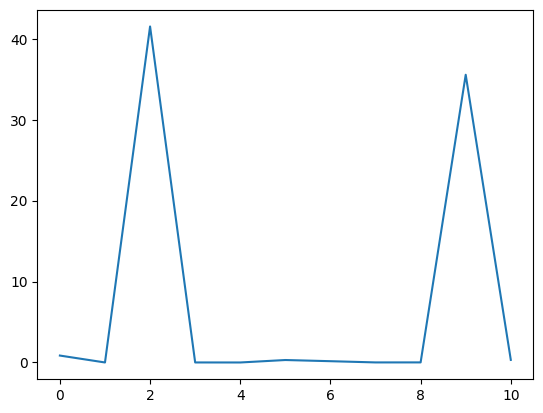

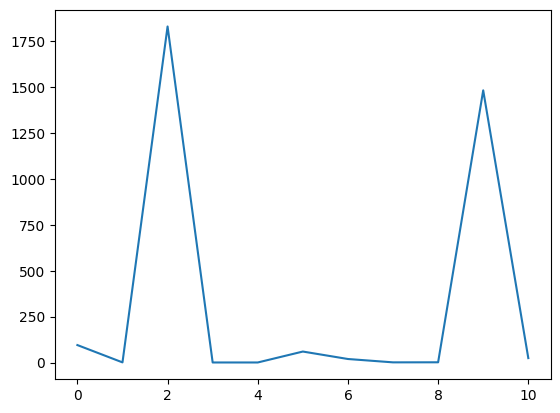

In [ ]:
HessianEigList = []
HessianEigNormList = []
TargetList = []
idx_list = []
HessianNormList_Functional = []
for i, (inputs, labels) in tqdm(enumerate(trainloader2)):
  idx_list.append(i)
  TargetList.append(labels)
  hessian_comp = pyhessian.hessian(net, criterion, data=(inputs, labels))
  top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=3)
  HessianEigList.append( top_eigenvalues )
  HessianEigNormList.append( np.linalg.norm(HessianEigList[-1])  )
  inputs, targets = inputs.to(device), labels.to(device)
  TARGET = targets
  H = torch.autograd.functional.hessian(f, inputs) #, vectorize=True, outer_jacobian_strategy='forward-mode'
  HessianNormList_Functional.append( torch.linalg.norm(H).to('cpu').detach().numpy() )
  print(idx_list[-1], TargetList[-1], HessianEigList[-1], HessianEigNormList[-1], HessianNormList_Functional[-1])
  if i == 10:
    break
plt.plot(HessianNormList_Functional)
plt.show()
plt.plot(HessianEigNormList)
plt.show()

In [ ]:
hess_fwdfwd =  jacfwd(jacfwd(Func.f))(inputs[0:1])

In [ ]:
len(trainset.data)

50000

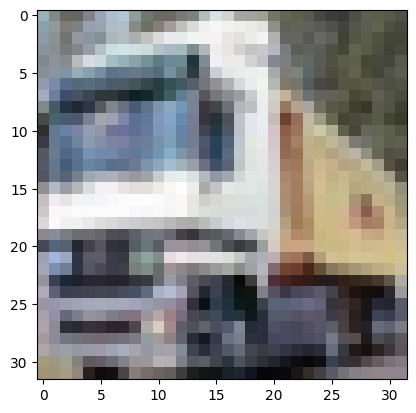

In [ ]:
plt.imshow(trainset.data[1])

9

In [ ]:
len(trainset.targets)

50000

In [ ]:
testloader.dataset.data[0:1].shape

(1, 32, 32, 3)

In [ ]:
grads = torch.autograd.grad(f(testloader.dataset.data[0:1]), testloader.dataset.data[0:1], create_graph=True)
H = torch.zeros((2, 2))

for i in range(2):
    for j in range(2):
        H[i, j] = torch.autograd.grad(grads[0][i], x, retain_graph=True)[0][j]